In [45]:
import re
import json
import pickle
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [47]:
def clean_str(s):
    return re.sub(r'\s', '', s)

def are_equal(a , b):
    return clean_str(a) == clean_str(b)

def a_in_b(a , b):
    return clean_str(a) in clean_str(b)

def add_cols (df, columns, default_value = 0):
    for k, e in enumerate(columns):
        i = common_data([e], df.columns, are_equal)

        if i == -1:
            df[e] = default_value
    return df

def common_data(list1, list2, comparisonf): 
    result = -1
  
    for k, x in enumerate(list1): 
        for y in list2: 
            
            if comparisonf(x,y):
                result = k
                return result  
                  
    return result

def prepare_data(df, feat2dummie, cols_to_pow, columns, drop_first = True, max_pow = 3):
    
    for i in feat2dummie:
        one_hot = pd.get_dummies(df[i], prefix=i, drop_first=drop_first)
        df = df.drop(i,axis = 1)
        df = df.join(one_hot)

    is_recid, is_violent_recid = df['is_recid'], df['is_violent_recid']

    columns_to_drop = ['is_recid', 'is_violent_recid']
    df = df.drop(columns_to_drop, axis=1)
    
    dft = df.copy()

    for k,i in enumerate(cols_to_pow):
        for j in range(1, max_pow):
            dft[i+str(j+1)] = pow(df[i], j+1)
    
    dft = add_cols(dft, columns)
    
    return dft, is_recid, is_violent_recid


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [48]:
pd.set_option('display.max_columns', None)

In [49]:
data_folder = './data'
model_folder = './model'
interpretation_result_folder = './audit_result'

train_dataset = 'train_compas_processed.xlsx'
validate_dataset = 'validate_compas_processed.xlsx'
model_colums_sample = 'model_colums_sample.xlsx'

model_file_name = 'rf_recidivism_prediction.sav'


interpretation_tree_filename = 'forest_tree_interpretation'

### Load data

In [50]:
train_df_init = pd.read_excel (data_folder+'/'+train_dataset)
validate_df_init = pd.read_excel (data_folder+'/'+validate_dataset)

train_df = train_df_init
validate_df = validate_df_init

In [51]:
columns = pd.read_excel (data_folder+'/'+model_colums_sample).columns

In [52]:
train_df.shape

(8918, 14)

In [53]:
validate_df.shape

(470, 14)

#### Prepare data for prediction

In [54]:
max_pow = 3
drop_first = True

feat2dummie = ['sex','age_cat','race','c_charge_degree','c_cat','weapon_firearm']
cols_to_pow = ['age','decile_score','priors_count','juv_count']

validate_df_processed, is_recid, is_violent_recid = prepare_data(validate_df, feat2dummie, cols_to_pow, columns, drop_first = True, max_pow = 3)

In [55]:
#df.shape

In [56]:
#df.head(10)

### Load model

In [57]:
rfc = pickle.load(open(model_folder+'/'+model_file_name, 'rb'))

In [58]:
train_df_processed, is_recid2, is_violent_recid2 = prepare_data(train_df, feat2dummie, cols_to_pow, columns, drop_first = True, max_pow = 3)

train_df_processed['prediction'] = rfc.predict(train_df_processed)

In [59]:
train_df_processed.head(10)

age  decile_score  priors_count  days_b_screening_arrest  \
0   31             3             0                       -5   
1   28             4             4                       -1   
2   41             2             1                       -1   
3   31             6             0                       -1   
4   24             3             1                       -1   
5   26             4             0                       -1   
6   24             7             2                       -1   
7   25             2             0                       -1   
8   31             9            13                       -1   
9   22             9             0                       -1   

   c_days_from_compas  juv_count  sex_Male  age_cat_Greater than 45  \
0                   5          0         0                        0   
1                   1          1         1                        0   
2                   1          0         1                        0   
3                   1          0         1                        0   
4                   1          0         0                        0   
5                   1          0         1                        0   
6                   1          0         0                        0   
7                   1          0         1                        0   
8                   1          4         1                        0   
9                   1          0         1                        0   

   age_cat_Less than 25  race_Asian  race_Caucasian  race_Hispanic  \
0                     0           0               1              0   
1                     0           0               0              0   
2                     0           0               1              0   
3                     0           0               0              0   
4                     1           0               0              0   
5                     0           0               0              0   
6                     1           0               1              0   
7                     0           0               0              0   
8                     0           0               0              0   
9                     1           0               0              0   

   race_Native American  race_Other  c_charge_degree_M  c_cat_battery  \
0                     0           0                  1              1   
1                     0           0                  0              0   
2                     0           0                  0              0   
3                     0           0                  0              0   
4                     0           0                  0              0   
5                     0           0                  1              1   
6                     0           0                  0              0   
7                     0           1                  0              0   
8                     0           0                  0              0   
9                     0           0                  0              0   

   c_cat_burglary  c_cat_cannabis  c_cat_driving  c_cat_grand theft  \
0               0               0              0                  0   
1               0               0              0                  1   
2               1               0              0                  0   
3               0               0              0                  0   
4               0               0              0                  0   
5               0               0              0                  0   
6               0               0              0                  0   
7               0               0              0                  0   
8               0               0              0                  0   
9               0               0              0                  1   

   c_cat_lewdness  c_cat_mischief  c_cat_no charge  c_cat_other  c_cat_poss  \
0               0               0                0            0           0   
1           

In [60]:
train_df['prediction'] = train_df_processed['prediction']

Confusion matrix, without normalization
[[5886    0]
 [3032    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


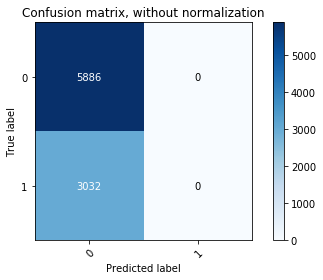

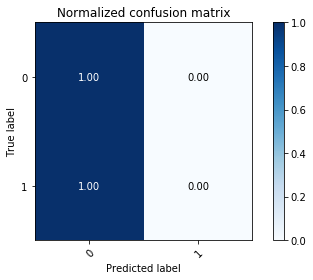

In [61]:
# Plot non-normalized confusion matrix
class_names = np.array(['0','1'])
plot_confusion_matrix(is_recid2, train_df['prediction'], classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(is_recid2, train_df['prediction'], classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 1. Bias detection in the data

Required data preprocessing. True labels should be in column `label_value`, predicted labels in column `score`. Any other column passed to `BiasDetection` class will be considered as protected property and statistical tests will be run on it

In [62]:
bias_df = train_df[['prediction', 'is_recid', 'race', 'sex', 'age_cat']]
bias_df = bias_df.rename(columns={'is_recid':'label_value', 'prediction':'score'})
bias_df.head()

score  label_value              race     sex       age_cat
0      0            0         Caucasian  Female       25 - 45
1      0            0  African-American    Male       25 - 45
2      0            1         Caucasian    Male       25 - 45
3      0            0  African-American    Male       25 - 45
4      0            0  African-American  Female  Less than 25

In [63]:
import bias_detection.bias_detection as bd

bias = bd.BiasDetection(bias_df)

ModuleNotFoundError: No module named 'aequitas'

### Analysing dataset bias

In [64]:
bias.

SyntaxError: invalid syntax (<ipython-input-64-407a7ed7092b>, line 1)

First of all, we check the bias of a model and a dataset itself. For the dataset bias, we require that protected properties of an individual do not have a strong influence on the decision. That is, the library splits the dataset into groups based on protected property. If the percentage of positive labels is beyond [20% neighborhood](https://en.wikipedia.org/wiki/Disparate_impact) for all groups, then it is deemed to have a bias in respect to that protected property.

In [49]:
import pprint

dataset_bias_info = bias.check_dataset_bias()

pp = pprint.PrettyPrinter()
pp.pprint(dataset_bias_info)

{'details': {'age_cat': {'fair': False,
                         'ratios': {'25 - 45': 0.3452615021627998,
                                    'Greater than 45': 0.23901673640167365,
                                    'Less than 25': 0.4234375}},
             'race': {'fair': False,
                      'ratios': {'African-American': 0.40743243243243243,
                                 'Asian': 0.17073170731707318,
                                 'Caucasian': 0.28217503217503215,
                                 'Hispanic': 0.2542372881355932,
                                 'Native American': 0.3076923076923077,
                                 'Other': 0.24253731343283583}},
             'sex': {'fair': True,
                     'ratios': {'Female': 0.24415443175638935,
                                'Male': 0.3640344681452182}}},
 'fair': False}


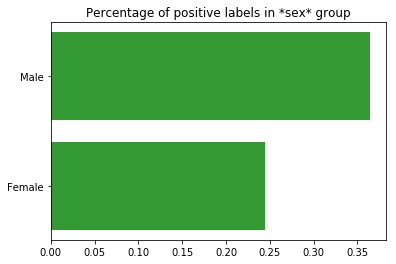

In [50]:
bias.plot_dataset_bias(dataset_bias_info, 'sex')

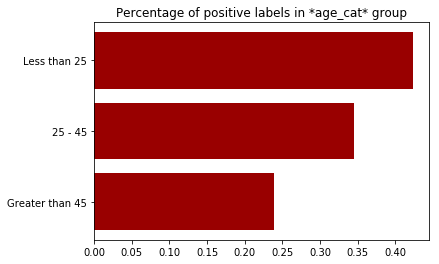

In [51]:
bias.plot_dataset_bias(dataset_bias_info, 'age_cat')

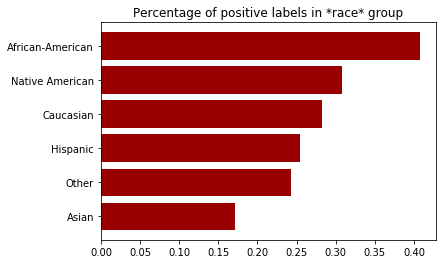

In [52]:
bias.plot_dataset_bias(dataset_bias_info, 'race')

### Analysing model bias

Now we analise the bias of the model itself. We can get bias summary with reqired level of detalization with `get_model_fairness` function. Available levels are `model`, `attribute`, and `value`. Each gives overview of fairness on model, attribute, and groups within each attribute (all kind of races) respectively

In [53]:
bias.get_model_fairness(level='model')

model_id, score_thresholds 1 {'rank_abs': [0]}
get_disparity_major_group()


{'Overall Fairness': False,
 'Supervised Fairness': False,
 'Unsupervised Fairness': True}

In [54]:
bias.get_model_fairness(level='attribute')

model_id, score_thresholds 1 {'rank_abs': [0]}
get_disparity_major_group()


model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         1      binary 0/1        age_cat                 NaN            NaN   
1         1      binary 0/1           race                 NaN            NaN   
2         1      binary 0/1            sex                 NaN            NaN   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0         NaN         NaN       False        True         NaN        True   
1         NaN         NaN       False        True         NaN        True   
2         NaN         NaN       False        True         NaN        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True               NaN           NaN          False             NaN   
1       False               NaN           NaN          False             NaN   
2        True               NaN           NaN          False             NaN   

   Unsupervised Fairness  Supervised Fairness  
0                    NaN                False  
1                    NaN                False  
2                    NaN                False

In [55]:
bias.get_model_fairness(level='value')

model_id, score_thresholds 1 {'rank_abs': [0]}
get_disparity_major_group()


model_id score_threshold  k attribute_name   attribute_value  tpr  tnr  \
0          1      binary 0/1  0           race  African-American  0.0  1.0   
1          1      binary 0/1  0           race             Asian  0.0  1.0   
2          1      binary 0/1  0           race         Caucasian  0.0  1.0   
3          1      binary 0/1  0           race          Hispanic  0.0  1.0   
4          1      binary 0/1  0           race   Native American  0.0  1.0   
5          1      binary 0/1  0           race             Other  0.0  1.0   
6          1      binary 0/1  0            sex            Female  0.0  1.0   
7          1      binary 0/1  0            sex              Male  0.0  1.0   
8          1      binary 0/1  0        age_cat           25 - 45  0.0  1.0   
9          1      binary 0/1  0        age_cat   Greater than 45  0.0  1.0   
10         1      binary 0/1  0        age_cat      Less than 25  0.0  1.0   

         for  fdr  fpr  fnr       npv  precision  pp    pn  ppr  pprev  fp  \
0   0.407432  NaN  0.0  1.0  0.592568        NaN   0  4440  NaN    0.0   0   
1   0.170732  NaN  0.0  1.0  0.829268        NaN   0    41  NaN    0.0   0   
2   0.282175  NaN  0.0  1.0  0.717825        NaN   0  3108  NaN    0.0   0   
3   0.254237  NaN  0.0  1.0  0.745763        NaN   0   767  NaN    0.0   0   
4   0.307692  NaN  0.0  1.0  0.692308        NaN   0    26  NaN    0.0   0   
5   0.242537  NaN  0.0  1.0  0.757463        NaN   0   536  NaN    0.0   0   
6   0.244154  NaN  0.0  1.0  0.755846        NaN   0  1839  NaN    0.0   0   
7   0.364034  NaN  0.0  1.0  0.635966        NaN   0  7079  NaN    0.0   0   
8   0.345262  NaN  0.0  1.0  0.654738        NaN   0  5086  NaN    0.0   0   
9   0.239017  NaN  0.0  1.0  0.760983        NaN   0  1912  NaN    0.0   0   
10  0.423438  NaN  0.0  1.0  0.576562        NaN   0  1920  NaN    0.0   0   

      fn    tn  tp  group_label_pos  group_label_neg  group_size  \
0   1809  2631   0             1809             2631        4440   
1      7    34   0                7               34          41   
2    877  2231   0              877             2231        3108   
3    195   572   0              195              572         767   
4      8    18   0                8               18          26   
5    130   406   0              130              406         536   
6    449  1390   0              449             1390        1839   
7   2577  4502   0             2577             4502        7079   
8   1756  3330   0             1756             3330        5086   
9    457  1455   0              457             1455        1912   
10   813  1107   0              813             1107        1920   

    total_entities      prev  ppr_disparity  pprev_disparity  \
0             8918  0.407432            NaN              NaN   
1             8918  0.170732            NaN              NaN   
2             8918  0.282175            NaN              NaN   
3             8918  0.254237            NaN              NaN   
4             8918  0.307692            NaN              NaN   
5             8918  0.242537            NaN              NaN   
6             8918  0.244154            NaN              NaN   
7             8918  0.364034            NaN              NaN   
8             8918  0.345262            NaN              NaN   
9             8918  0.239017            NaN              NaN   
10            8918  0.423438            NaN              NaN   

    precision_disparity  fdr_disparity  for_disparity  fpr_disparity  \
0                   NaN            NaN       1.000000            NaN   
1                   NaN            NaN       0.419043            NaN   
2                   NaN            NaN       0.692569            NaN   
3                   NaN            NaN       0.623999            NaN   
4                   NaN            NaN       0.755198            NaN   
5                   NaN            NaN       0.595282            NaN   
6                   NaN            NaN  

Below we can see some useful visualization of fairness for `value` level with `plot_fairness` function. Red and green colors indicates which values are classified fairly by model and which aren't. There are two modes for visualization: with absolute and relative values respectively

model_id, score_thresholds 1 {'rank_abs': [0]}
get_disparity_major_group()


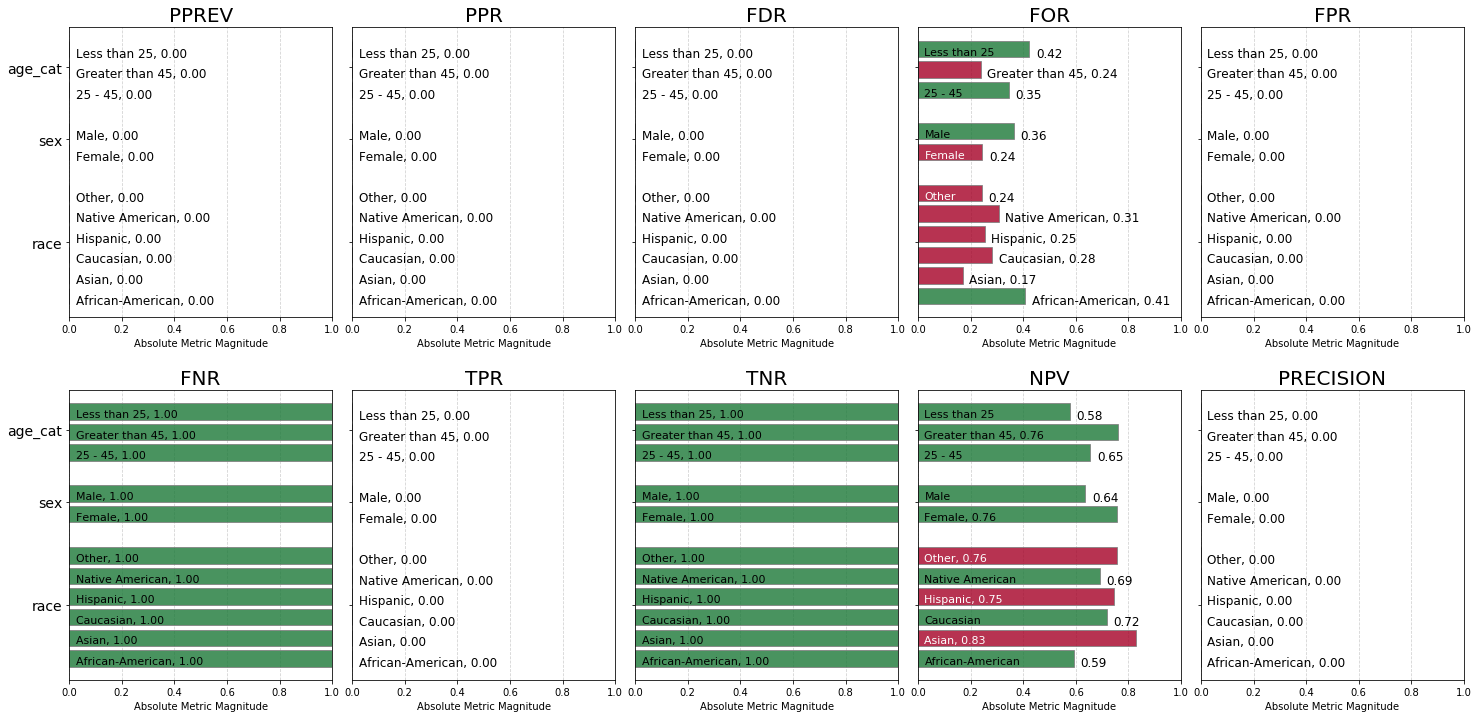

In [56]:
fg = bias.plot_fairness(is_absolute=True)

model_id, score_thresholds 1 {'rank_abs': [0]}
get_disparity_major_group()


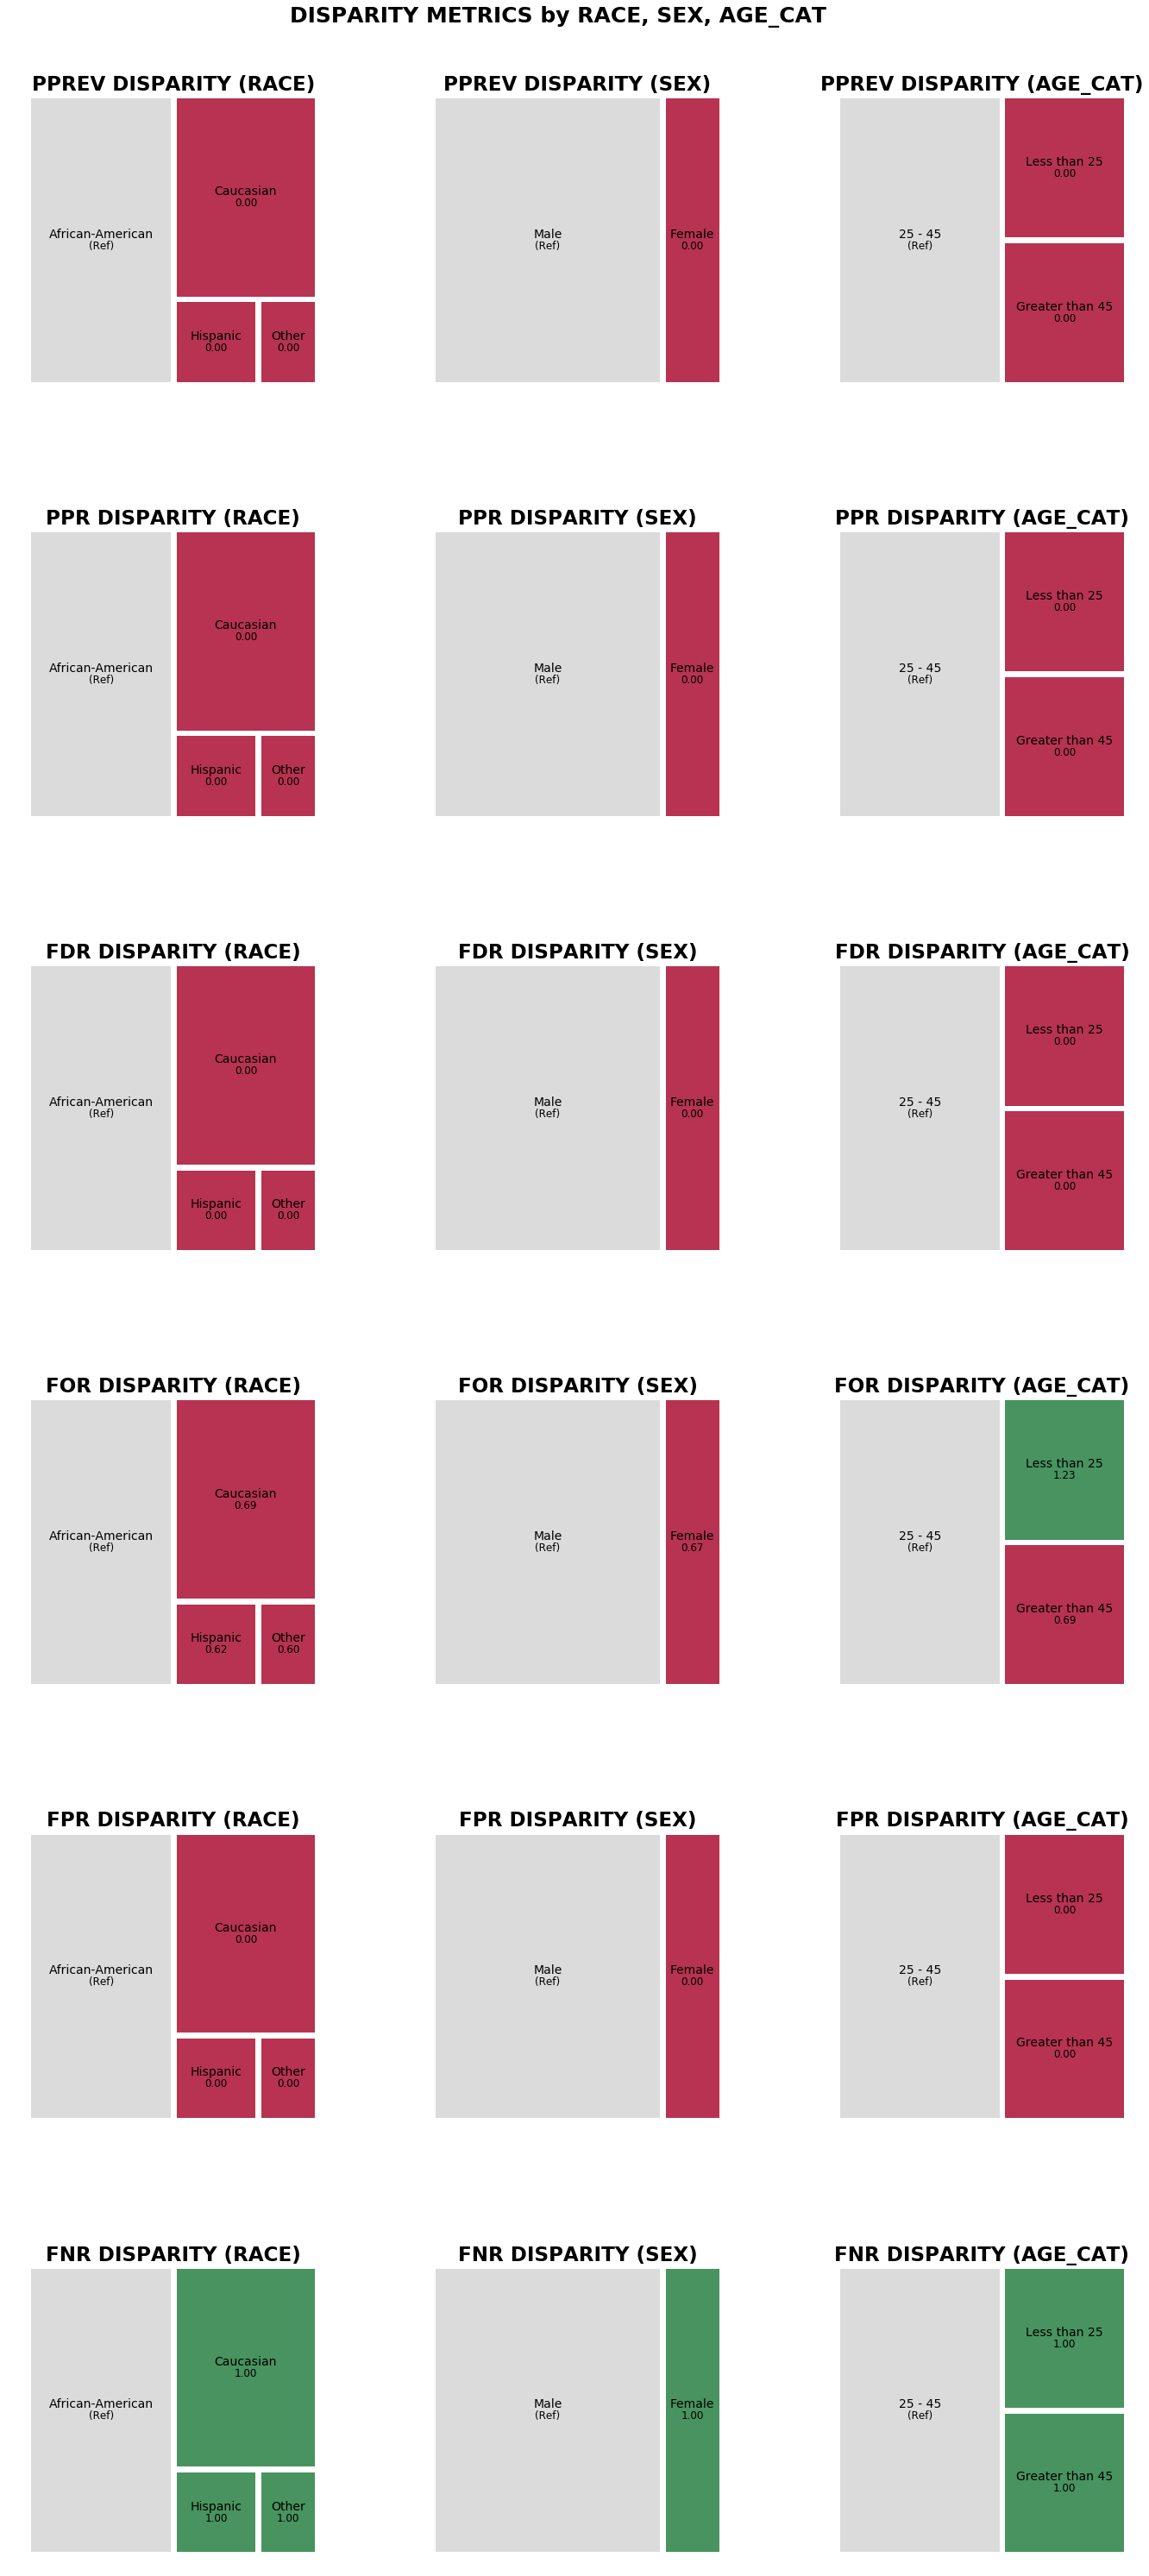

In [57]:
fg = bias.plot_fairness(is_absolute=False)

## 2. Feature selection from the data

### Oleg M

In [65]:
from feature_selection.feature_selector import FeatureSelector

### Loading splitted training and testing data

In [66]:
train_x = pd.read_csv(data_folder + '/' + 'train_x.csv')
test_x = pd.read_csv(data_folder + '/' + 'test_x.csv')

train_y = pd.read_csv(data_folder + '/' + 'train_y.csv')
test_y = pd.read_csv(data_folder + '/' + 'test_y.csv')

### Initializng FeatureSelector with RF model and data

In [67]:
feature_selector = FeatureSelector(rfc, train_x, test_x, train_y, test_y, train_x.columns)

Initiating FeatureSelector...
Done.
-----------------------------------
Creating interpretator for model
Done.
-----------------------------------
Building SHAP explainer for Tree Model
Done.
-----------------------------------
Computing SHAP values for first 100 test samples...
Attention! For a large dataset this procedure could take a while.
Done.


### Calculate and plot feature importance in the output of RF model

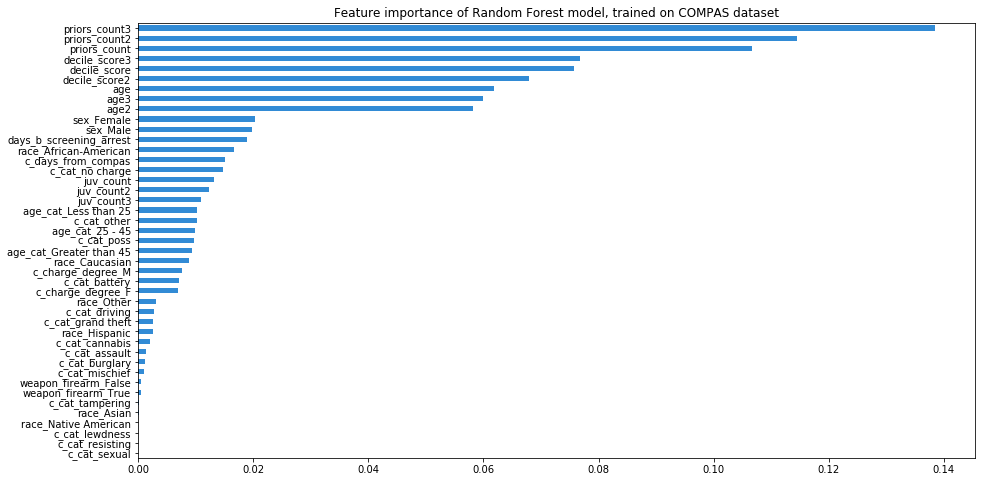

In [68]:
feature_selector.featureImportance()

### Calculate and plot partial dependence of different features with the output of the model

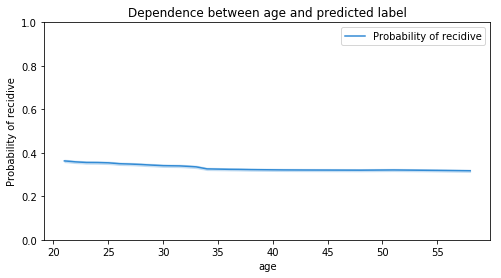

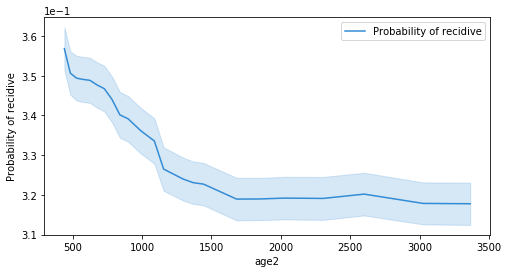

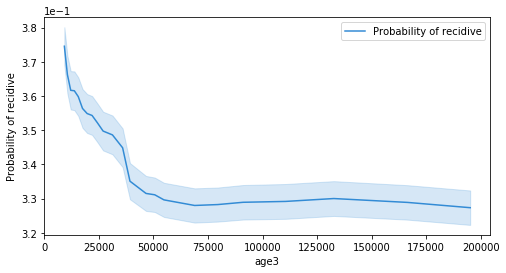

In [69]:
feature_selector.partialDependence(['age', 'age2', 'age3'])

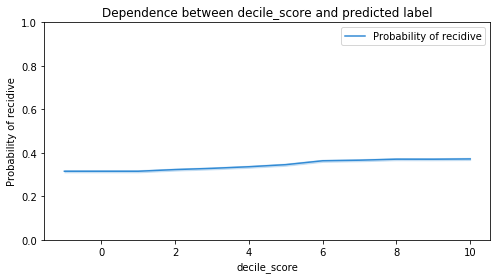

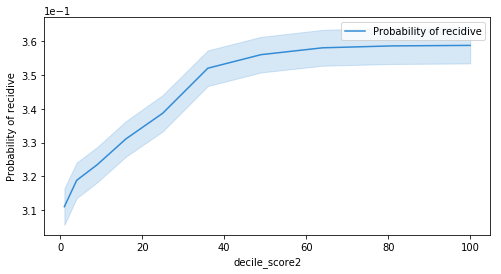

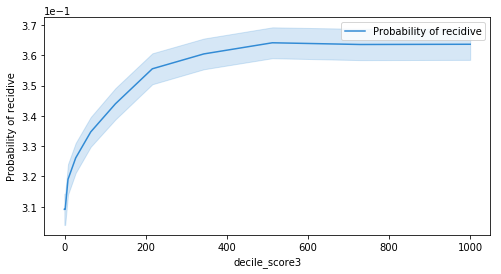

In [70]:
feature_selector.partialDependence(['decile_score', 'decile_score2', 'decile_score3'])

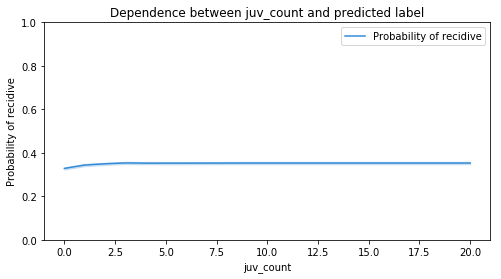

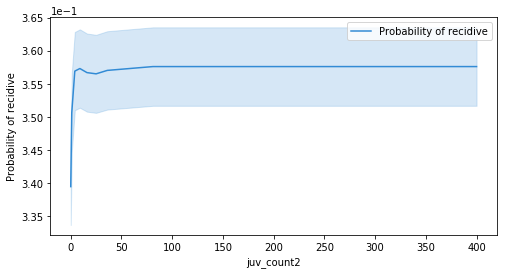

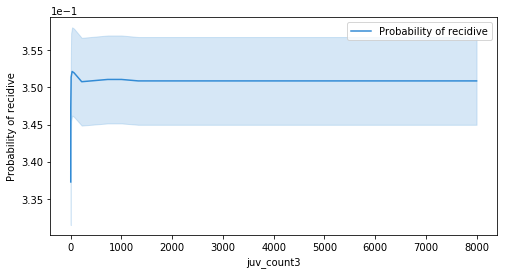

In [71]:
feature_selector.partialDependence(['juv_count', 'juv_count2', 'juv_count3'])

### Calculating SHAP values 

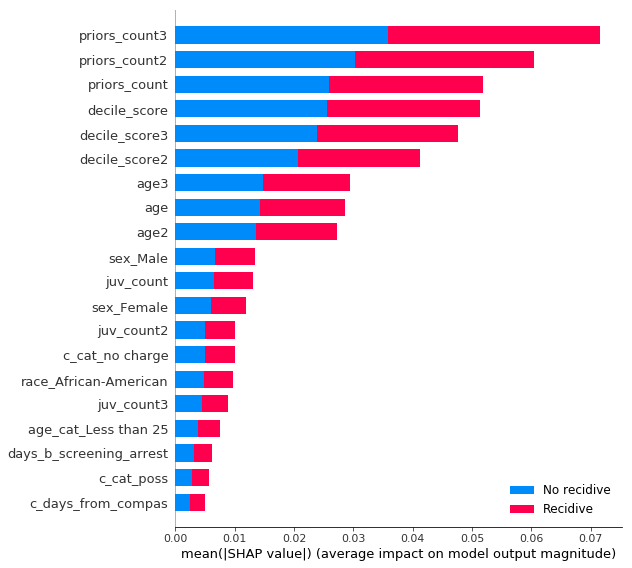

In [72]:
feature_selector.shapSummaryPlot()

## 3. Result interpretability

### Valerii & Andrew

In [31]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [33]:
pred_result = rfc.predict(validate_df_processed)

In [ ]:
result = roc_auc_score(is_recid, pred_result)

print(result)

#### Create and plot tree interpretation

In [34]:
from result_interpretation import ModelInterpreter

model_interpreter = ModelInterpreter(rfc, 
                                     train_df_processed.drop('prediction', axis=1), 
                                     train_df_processed['prediction'])

  warnings.warn(msg, DataConversionWarning)



In [35]:
model_interpreter.explain_instance(train_df_processed.drop('prediction', axis=1).iloc[0, :])

In [36]:
model_interpreter.print_instance_tree_interpretation(train_df_processed.drop('prediction', axis=1).iloc[[0]])

                         value_variable  contribution_variable
priors_count                        3.0                  0.056
juv_count3                          0.0                  0.043
juv_count2                          0.0                  0.037
age3                            74088.0                  0.009
race_Caucasian                      1.0                  0.009
days_b_screening_arrest             0.0                  0.006
c_cat_driving                       0.0                  0.002
weapon_firearm_True                 0.0                  0.002
race_Other                          0.0                  0.002
decile_score                        4.0                  0.001
c_cat_poss                          1.0                  0.001
race_Asian                          0.0                  0.001
c_cat_lewdness                      0.0                  0.001
age_cat_Less than 25                0.0                  0.001
age2                             1764.0                

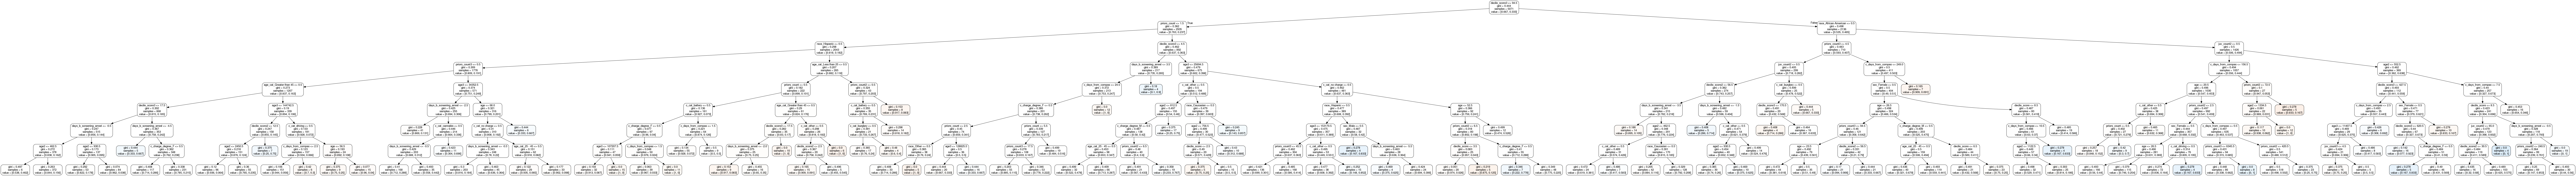

In [38]:
interpretation_plots = model_interpreter.visualize_tree([rfc.estimators_[2]], columns)

from IPython.display import Image
Image(filename = interpretation_plots[0])